### 金融情感词袋构建
#### 郑宇浩 41621101
#### 该文件主要对应于论文中的注释[9]，实现金融情感词袋的获取，最终结果保存于“微博评论获取”文件夹下

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
path=os.path.abspath('.')

#### 1. 数据导入与清洗：请务必先将所需文件Upload到jupyter中，文件位于与该notebook同目录下的文件夹，文件名为个股研报.xlsx

In [2]:
import jieba
from string import punctuation as punc
punc=punc+" 、，；：‘’“”—。？！……【】（）《》－"

df=pd.read_excel(path+"\个股研报.xlsx",encoding = "gb18030")

def cut_words(text): # 去除文本当中的标点符号
    clean="".join(w for w in text if w not in punc)
    clean=" ".join(jieba.cut(clean))
    return clean
df["cut_words"]=df["analysis"].apply(cut_words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\PC\AppData\Local\Temp\jieba.cache
Loading model cost 1.458 seconds.
Prefix dict has been built succesfully.


#### 2. 金融词袋建立

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# df.strategy为个股研报中的投资建议，买入记为1，卖出记为0，作为分类标签

X=df[["analysis"]]
X["cut_words"]=df["cut_words"]
y=df.strategy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20190521)

# 切词后去除停词，构建未分类的金融词袋

def get_custom_stopwords(stop_words_file): # 读取存储停词的文档，构建存储停词的数组并返回
    with open(stop_words_file,encoding = "utf-8-sig") as f:
        stopwords = f.read()
    stopwords_list = stopwords.split('\n')
    custom_stopwords_list = [i for i in stopwords_list]
    return custom_stopwords_list

stopwords = get_custom_stopwords(path+"\stopwordsHIT.txt")
max_df = 0.8 # 词汇出现总频率大于80%则认为太过于普通
min_df = 3 # 词汇出现总次数小于3则认为太过于特殊
vect = CountVectorizer(max_df = max_df,min_df = min_df,stop_words=stopwords) # 去除停词，设置词汇出现的最低次数与最高频率限制
term_matrix = pd.DataFrame(vect.fit_transform(X_train.cut_words).toarray(), columns=vect.get_feature_names()) # 生成未分类的金融词袋

F:\Anaconda\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [4]:
term_matrix.head()

,016,10,101,12,138,15,17,18,19,1920,...,需求,面临,项目,预测,领先,领域,驾驶,高于,高速,龙头
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,4,0,1,0
1,0,0,1,0,1,0,0,1,1,0,...,1,0,1,0,0,0,0,0,0,0
2,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0
3,0,0,0,0,0,0,1,3,4,2,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,1,0,0,0,3


#### 3. 分类模型训练

In [5]:
# 利用交叉验证法为模型在训练集内的表现评分

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB() # 运用朴素贝叶斯分类算法
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(vect, nb) # 构建数据处理管道对词汇进行朴素贝叶斯分类
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X_train.cut_words, y_train, cv=3, scoring='accuracy').mean() # 交叉验证

0.8214285714285715

#### 4. 分类模型测试

In [6]:
# 将模型运用于测试集

pipe.fit(X_train.cut_words, y_train)
from sklearn import metrics
y_pred = pipe.predict(X_test.cut_words)
metrics.accuracy_score(y_true = y_test,y_pred = y_pred)

0.9130434782608695

Text(0.5,16,'true label')

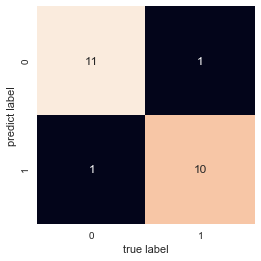

In [7]:
# 生成混沌矩阵

from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set()
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1], yticklabels = [0,1])
plt.ylabel('predict label')
plt.xlabel('true label')